### Import dependencies and functions needed

In [85]:
import pandas as pd
import math
import numpy as np
import datetime as dt
import time
import yfinance as yf
from numpy import linalg as la
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import statistics
import os
from PIL import Image as img
from scipy.optimize import minimize

#we define our functions on this cell. 
FactorFlag = 1 # set factor flag to 1 for four factor
NumPeriods = 50
MaxAssets = 100

## ----------- FILTER COVID ------------ ##
def filter_covid(df):
    df.reset_index(inplace= True)
    df.set_index('Date', inplace= True)
    mask = (df.index < '2020-01-01') | (df.index  > '2020-09-01')
    no_covid_data = df.loc[mask, :]
    no_covid_data.reset_index
    return no_covid_data

def ComputePCA_GPS(S, Srank, Sdim):
    evalues, evectors = la.eigh(S)
    h = [] # all our eigenvectors \beta, F1, F2, F3
    sp2 = [] # corresponding eigenvalues

    for i in range(1, 5): 
        h.append(evectors[:, -i])
        sp2.append(evalues[-i])

    lp2 = (np.sum(evalues ) -sp2[0] ) /(Srank -1)
    psi2 = (sp2[0] - lp2) / sp2[0]  # this is the psi^2 term from the GPS paper
    all_ones = np.ones(Sdim)
    q = all_ones / la.norm(all_ones) #north pole, unit vector

    hq = np.dot(h[0], q)  # inner product of h and q
    if hq < 0:
        h[0] = -h[0]  # choose e-vector h with positive mean
        hq = -hq
    elif hq == 0:
        print("error: h is orthogonal to q")

    tau = (1 - psi2) * hq / (psi2 - hq * hq)  # equation (21) from the dispersion bias
    h_shr = h[0] + tau * q  # h_GPS before normalizing

    h_shr_norm = (1/la.norm(h_shr))*h_shr #h_GPS normalized

    for i in range(1,4):  # now lets normalize the rest of the principal componenets
        h[i] = (1/la.norm(h[i]))*h[i]

    # up to here we have computed a list of our first four principal components normalized except for PCA, and their respective eigenvalues
    # h_shr_norm which is our corrected beta vector

    # now depending on the flag we will return two different things

    if FactorFlag == 0: 
        return h[0], h_shr_norm, sp2[0], lp2 # PCA principal comp, JSE prinpcal comp, leading eigenval, avg of rest eigenvals
    elif FactorFlag == 1: 
        return h, h_shr_norm, sp2 # Principal Components list, JSE princiapl comp, Corresponding eigenvalues. 
    else: 
        print('please correct flag')
    
            
def Compute_Zmatrix_cost(
    x, Bstar, Returns, 
    ) -> float:
    error = Returns - np.matmul(Bstar, x)
    returnVALUE = np.linalg.norm(error, 2)**2
    return returnVALUE

def getJSE_BSTAR(
    h, h_JSE
    ) -> list:
    H = np.array(h)
    H[0] = np.array(h_JSE)
    return H


def Compute_Zmatrix( # Function returns the JSE and PCA residuals matrix (keep at low experiments for quick tests)
    Returns: list
    ) -> list:
    Returns = Returns.to_numpy()
    numFactors = 4
    initialGuess = np.random.randn(numFactors)  # The initial guess for scipy optimizer
    # Z = np.zeros((MaxAssets, NumPeriods))  # The Residuals matrix
    # Z_jse = np.zeros((MaxAssets, NumPeriods))  # The Residuals matrix for JSE

    R_exper = Returns.T
    S = np.matmul(R_exper, R_exper.transpose()) / NumPeriods  # Create the Sample covariance matrix for experiment i
    h, h_JSE, sp2 = ComputePCA_GPS(S, NumPeriods, len(S))

    Bstar = np.array(h).T  # This is the BSTAR in better betas, factor exposures
    Bstar_JSE = np.array(getJSE_BSTAR(h,h_JSE)).T  # This is the BSTAR for JSE

    psi_exp_i = np.zeros((4, NumPeriods)) 
    psi_exp_i_jse = np.zeros((4,NumPeriods))

    for j in range(NumPeriods):
        R_day = R_exper[:, j] # returns matrix is a 100 x 50 

        psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient 
        args =(Bstar,np.reshape(R_day, (MaxAssets,))),
        options = {'maxiter':10000, 'maxfev':10000, 'xatol': 1e-8, 'disp': True})

        psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
        args =(Bstar_JSE,np.reshape(R_day, (MaxAssets,))),
        options = {'maxiter':10000, 'maxfev':10000, 'xatol': 1e-8, 'disp': True})

        
        psi_exp_i[:, j] = psi_day.x
        psi_exp_i_jse[:, j] = psi_day_jse.x

    Z = R_exper - np.matmul(Bstar, psi_exp_i)   # Residuals for regular PCA
    Z_jse = R_exper - np.matmul(Bstar_JSE, psi_exp_i_jse)  # Residuals for JSE

    return Z, Z_jse


def ComputeMRPortfolio(
    h, **kwargs  # computes weights for one factor covariance matrix:
    ) -> list:
    
    our_args = kwargs
    all_ones = np.ones(MaxAssets)
    
    if 'svar' in our_args:
        
        d2 = kwargs['svar']
        sigma2 = kwargs['mvar']
        Omega = sigma2*np.diag([1]*4) # this creates Omega diagonal (17)
        Delta = d2*np.diag([1]*MaxAssets) # this creates Delta diagonal in (17)
        cov_est = np.dot(np.dot(np.array(h).T, Omega), np.array(h)) + Delta # this is (17)
        w_num = np.dot(np.linalg.inv(cov_est),all_ones) # numerator of solving for w
        w = w_num/np.dot(all_ones.T,w_num) # final computation solving for w
    
    elif 'svar_l' in our_args:
        
        d2 = kwargs['svar_l']
        sigma2_l = kwargs['mvar_l']
        Omega = np.diag(sigma2_l) # we are given the real market variances
        Delta = np.diag(d2) # we are given the real d2 or specific variances
        cov_est = np.dot(np.dot(np.array(h).T, Omega), np.array(h)) + Delta # this is (17)
        w_num = np.dot(np.linalg.inv(cov_est),all_ones) # numerator of solving for w
        w = w_num/np.dot(all_ones.T,w_num) # final computation solving for w
        
    else: 
        
        p_eta = kwargs['p_eta']
        delta2 = kwargs['delta2']
        q = all_ones / la.norm(all_ones)  # north pole, unit vector
        hq = np.dot(h, q) # hq is just the h vector in the direction of the north pole
        k2 = delta2 / p_eta
        rho = (1 + k2) / hq
        w = ((rho * q) - h) / ((rho - hq) * np.sqrt(MaxAssets))
    
    return w


def inSampleTest(period: str, return_type: str, num_assets: int, tframe: int):
    
#valid periods: '1mo', '3mo', '6mo' ,'1y', '2y', '5y', '10y', 'max' 
#valid time interval: '1d', '5d', '1wk', '1mo', '3mo'
#num_assets x tframe is the dimension of the covariance matrix
#period is how long our historical data goes back
#return_type is simply the type of returns we are looking at: 'daily', 'weekly', 'monthly' etc

    #pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] #collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) #organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') #cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)

    #the insample test

    #variance list
    varJSE = []
    varPCA = []
    varRAW = []

    #list of portfolio weights for each period
    p_JSE = []
    p_PCA = []
    p_RAW = []

    #computeInSampleVar():
    
    for i in range(0,len(sampleData_pct)-tframe): #subtract 2 from the length i
        tempdf = sampleData_pct.iloc[i:tframe+i, :] #current month frame
        tempSample_cov = tempdf.cov() 
        
        rank = len(tempdf)
        dimension = len(tempSample_cov)
        
        h, h_GPS, sp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) #leading ev, JSE ev, leading evalue of S, ell^2 
        h_GPS = getJSE_BSTAR(h, h_GPS)
       ## regular residuals ##
        Z, Z_jse = Compute_Zmatrix(tempdf)
        S = tempSample_cov
        z = Z
        z = np.sum(z**2, axis = 1) # square and sum across time
        d2n = (1/NumPeriods)*z # this is the calculation for equation (21) in better betas
        d2n_avg = np.sum(d2n)/len(d2n) # (22) bb
        sigma2 = sp2[0] - d2n_avg # (23) bb
        d2_mp = (np.trace(S) - np.sum(sp2))/(MaxAssets - 4*(1 - MaxAssets/NumPeriods)) # Marchenko-Pastur correction
        sigma2_mp = sp2[0] - d2_mp*(1 + MaxAssets/NumPeriods) # Marchenko-Pastur correction for market variance

        ## jse residuals ##
        z_jse = Z_jse
        z_jse = np.sum(z_jse**2, axis = 1) # square and sum across time
        d2n_jse = (1/NumPeriods)*z_jse # this is the calculation for equation (21) in better betas
        d2n_avg_jse = np.sum(d2n_jse)/len(d2n_jse) # (22) bb
        sigma2_jse = sp2[0] - d2n_avg_jse # (23) bb
        d2_mp_jse = (np.trace(S) - np.sum(sp2))/(MaxAssets - 4*(1 - MaxAssets/NumPeriods)) # Marchenko-Pastur correction
        sigma2_mp_jse = sp2[0] - d2_mp_jse*(1 + MaxAssets/NumPeriods) # Marchenko-Pastur correction for market variance

        ## weights ##
        w_Epca = ComputeMRPortfolio(h, mvar = sigma2_mp, svar = d2_mp)  # weights 4 factor corrected market and specific variance
        w_Ejse = ComputeMRPortfolio(h_GPS, mvar = sigma2_mp_jse, svar = d2_mp_jse)  # weights 4 factor corrected beta vector and variances
        w_raw = ComputeMRPortfolio(h, mvar = sigma2, svar = d2n)  # weights 4 factor regular variance estimates as well as regular beta vector
        
        #all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        #variances
        
        jse_var = np.dot(w_Ejse.T, np.dot(tempSample_cov, w_Ejse))*100
        pca_var = np.dot(w_Epca.T, np.dot(tempSample_cov, w_Epca))*100
        raw_var = np.dot(w_raw.T, np.dot(tempSample_cov, w_raw))*100
        
        #appending current in sample variance to the list
        
        varJSE.append(jse_var)
        varPCA.append(pca_var)
        varRAW.append(raw_var)

    first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')

    return varJSE, varPCA, varRAW, time_horizon

def outSampleTest(period, return_type, num_assets, obs, outOfSample): 
    # pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] # collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) # organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') # cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    sampleData_pct = filter_covid(sampleData_pct)
    ## the rollling out of sample test ##

    varianceJSE = []
    variancePCA = []
    varianceRAW = []
    
    # list of portfolio weights per iteration
    p_JSE = []
    p_PCA = []
    p_RAW = []
    
    _time = []
    # computeOutSampleVar():
    
    for i in range(0,len(sampleData_pct)-obs-outOfSample): # subtract 2 from the length i

        tempdf = sampleData_pct.iloc[i:obs+i, :] # current month frame
        tempSample_cov = tempdf.cov()

        cur_yr = sampleData_pct.reset_index().loc[obs+i, 'Date'].year
        cur_mo = sampleData_pct.reset_index().loc[obs+i, 'Date'].month
        cur_day = sampleData_pct.reset_index().loc[obs+i, 'Date'].day
        _time.append(str(cur_mo) + '-' + str(cur_day) + '-' + str(cur_yr))
        

        rank = len(tempdf)
        dimension = len(tempSample_cov)
        
        h, h_GPS, sp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) #leading ev, JSE ev, leading evalue of S, ell^2 
        h_GPS = getJSE_BSTAR(h, h_GPS)
       ## regular residuals ##
        Z, Z_jse = Compute_Zmatrix(tempdf)
        S = tempSample_cov
        z = Z
        z = np.sum(z**2, axis = 1) # square and sum across time
        d2n = (1/NumPeriods)*z # this is the calculation for equation (21) in better betas
        d2n_avg = np.sum(d2n)/len(d2n) # (22) bb
        sigma2 = sp2[0] - d2n_avg # (23) bb
        d2_mp = (np.trace(S) - np.sum(sp2))/(MaxAssets - 4*(1 - MaxAssets/NumPeriods)) # Marchenko-Pastur correction
        sigma2_mp = sp2[0] - d2_mp*(1 + MaxAssets/NumPeriods) # Marchenko-Pastur correction for market variance

        ## jse residuals ##
        z_jse = Z_jse
        z_jse = np.sum(z_jse**2, axis = 1) # square and sum across time
        d2n_jse = (1/NumPeriods)*z_jse # this is the calculation for equation (21) in better betas
        d2n_avg_jse = np.sum(d2n_jse)/len(d2n_jse) # (22) bb
        sigma2_jse = sp2[0] - d2n_avg_jse # (23) bb
        d2_mp_jse = (np.trace(S) - np.sum(sp2))/(MaxAssets - 4*(1 - MaxAssets/NumPeriods)) # Marchenko-Pastur correction
        sigma2_mp_jse = sp2[0] - d2_mp_jse*(1 + MaxAssets/NumPeriods) # Marchenko-Pastur correction for market variance

        ## weights ##
        w_Epca = ComputeMRPortfolio(h, mvar = sigma2_mp, svar = d2_mp)  # weights 4 factor corrected market and specific variance
        w_Ejse = ComputeMRPortfolio(h_GPS, mvar = sigma2_mp_jse, svar = d2_mp_jse)  # weights 4 factor corrected beta vector and variances
        w_raw = ComputeMRPortfolio(h, mvar = sigma2, svar = d2n)  # weights 4 factor regular variance estimates as well as regular beta vector
        
        # all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        # list of portfolio returns
        
        p_returnJSE = []
        p_returnPCA = []
        p_returnRAW = []
        
        for j in range(obs+i,obs+i+outOfSample):
            p_returnJSE.append(np.dot(sampleData_pct.iloc[j], w_Ejse)*100)
            p_returnPCA.append(np.dot(sampleData_pct.iloc[j], w_Epca)*100)
            p_returnRAW.append(np.dot(sampleData_pct.iloc[j], w_raw)*100)
        
        # append out-of-sample variance

        varianceJSE.append(statistics.variance(p_returnJSE))
        variancePCA.append(statistics.variance(p_returnPCA))
        varianceRAW.append(statistics.variance(p_returnRAW))

        # end for loop

    # Time analysis for when called

    first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')
        

    return varianceJSE, variancePCA, varianceRAW, _time # variance of portfolio returns



def biasTest(period, return_type, num_assets, tframe, subset: int): 
    #pulling and cleaning data
    df = pd.read_excel("D:\Florida State University\Spring 23\JSE_git\HITM_Research\hitm_sp500.xlsx", sheet_name = 'sp500')
    df = df.iloc[0:num_assets]
    tickers = df['Symbol'] #collecting the tickers for the current sp500 stocks
    tickers = yf.Tickers(tickers.tolist()) #organizing tickers for yf library
    sampleData = tickers.history(period = period, actions = False, rounding = True, interval = return_type)['Close']
    sampleData = sampleData.dropna(how = 'all').fillna(method = 'bfill') #cleaning data
    sampleData_pct = sampleData.pct_change()
    sampleData_pct.dropna(inplace = True)
    
    #array of accumulated std
    acc_std = []
    
    #array of portfolio weights
    p_JSE = []
    p_PCA = []
    p_RAW = []
    
    #list of returns over standard deviation of model
    pnorm_JSE = []
    pnorm_PCA = []
    pnorm_RAW = []
    
    iterations = 0
    # pnorm_METHOD will be a collection of normalized returns, w
    
    for i in range(0,len(sampleData_pct)-tframe): #subtract 1 from the length i (we use "next month" data)
        tempdf = sampleData_pct.iloc[i:tframe+i, :] #current frame
        tempdf = tempdf.apply(lambda x: x - x.mean(axis = 0)) #demean the asset returns of the current window frame using current asset window frame means
        tempSample_cov = tempdf.cov()
        
        tempdf2 = sampleData_pct.iloc[i:tframe+i+1, :] #get the out of sample return x^(i) and demean  
        tempdf2 = tempdf2.apply(lambda x: x - x.mean(axis = 0))
        
        rank = len(tempdf) #the rank will be equal to the length of our dataframe = to the number of days/weeks/months
        dimension = len(tempSample_cov) #the dimension will just be the number of assets>>num_days/weeks/months
        
        h, h_GPS, sp2, lp2 = ComputePCA_GPS(tempSample_cov, rank, dimension) #leading ev, JSE ev, leading evalue of S, ell^2 
        p_eta_obs = sp2 - lp2
        delta2_raw = ((rank-1)/(dimension-1))*lp2
        delta2_obs = (rank/dimension)*lp2
        p_eta_raw = sp2 - delta2_raw
        
        w_Epca = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h)    # estimated evalues and PCA evector
        w_Ejse = ComputeMRPortfolio(dimension, p_eta_obs, delta2_obs, h_GPS) # estimated evalues and GPS evector
        w_raw = ComputeMRPortfolio(dimension, p_eta_raw, delta2_raw, h) # PCA evalue and evector
        
        #all the weights of the portfolios for the time frame
        p_JSE.append(w_Ejse)
        p_PCA.append(w_Epca)
        p_RAW.append(w_raw)
        
        #std of model
        
        cur_jse_std = math.sqrt(np.dot(w_Ejse, np.dot(tempSample_cov, w_Ejse)))
        cur_pca_std = math.sqrt(np.dot(w_Epca, np.dot(tempSample_cov, w_Epca)))
        cur_raw_std = math.sqrt(np.dot(w_raw, np.dot(tempSample_cov, w_raw)))
        
        #next month portoflios return/std

        pnorm_JSE.append((np.dot(tempdf2.iloc[-1], w_Ejse))/cur_jse_std)
        pnorm_PCA.append((np.dot(tempdf2.iloc[-1], w_Epca))/cur_pca_std)
        pnorm_RAW.append((np.dot(tempdf2.iloc[-1], w_raw))/cur_raw_std)
        
        iterations += 1

    subJSE = []
    subRAW = []
    subPCA = []
    for i in range(iterations-subset): #iterations is just how many times we went through our total data = len(sampleData_pct) - tframe = len(pnorm) = 96 for 10y/1mo 120mo - 24mo (tframe) = 96
        #we also use iterations - subset to make sure we dont go out of bounds
        subJSE.append(np.std(pnorm_JSE[i:subset+i]))
        subRAW.append(np.std(pnorm_RAW[i:subset+i]))
        subPCA.append(np.std(pnorm_PCA[i:subset+i]))

    #test to see how many intervals or subset required: 

    for i in range(len(pnorm_JSE)):
        acc_std.append(np.std(pnorm_JSE[0:i]))


    #we will try and get the time horizon to print return a string: 4/1/20 - 8/1/22

    #first we need to get the first date of the the first data frame
 
    first_year, first_month = sampleData_pct.index[0].year, sampleData_pct.index[0].month

    last_year, last_month = sampleData_pct.index[-1].year, sampleData_pct.index[-1].month

    time_horizon = str(f'Time:{first_month}/{first_year}-{last_month}/{last_year}')

    return subJSE, subPCA, subRAW, iterations, time_horizon, acc_std


### In sample test

In [81]:
varJSE, varPCA, varRAW, time_horizon1 = inSampleTest('10y', '1mo', MaxAssets, NumPeriods)

[*********************100%***********************]  100 of 100 completed
Optimization terminated successfully.
         Current function value: 0.312643
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.313534
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.332806
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.321891
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.148030
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.1499

<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient


Optimization terminated successfully.
         Current function value: 0.202004
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.216017
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.215687
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.214986
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.210464
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.179205
         Iterations: 1
         Function evaluations: 15
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

Optimization terminated successfully.
         Current function value: 0.229932
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.227754
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.198768
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.199180
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.226945
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.222498
         Iterations: 3
         Function evaluations: 35
         Grad

<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient



         Current function value: 0.210691
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.126384
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.125817
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.307232
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.303336
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.208796
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.214908
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.213674
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.137796
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.135943
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.239124
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.246307
         Iterations: 5
         Function evaluations: 50
         Gradient evaluations: 10
Optimization ter

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C


         Current function value: 0.136330
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.123976
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.123389
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.274898
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.277436
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.147993
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient



         Current function value: 0.224057
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.115756
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.116679
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.256397
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.276182
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.184676
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

Optimization terminated successfully.
         Current function value: 0.202069
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.198802
         Iterations: 5
         Function evaluations: 50
         Gradient evaluations: 10
Optimization terminated successfully.
         Current function value: 0.159421
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.158684
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.162816
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.160814
         Iterations: 3
         Function evaluations: 35
         Gra

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C

Optimization terminated successfully.
         Current function value: 0.138213
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.136317
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.242061
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.251926
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.268805
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.262746
         Iterations: 4
         Function evaluations: 40
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.201129
         Iterations: 2
         Function evaluations: 25
         Gradient evaluations: 5
Optimization terminated successfully.
         Current function value: 0.207693
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.134814
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.135176
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.121122
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.120749
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization term

<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

Optimization terminated successfully.
         Current function value: 0.168422
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.229235
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.230256
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.248103
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.248235
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.170628
         Iterations: 1
         Function evaluations: 15
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient


Optimization terminated successfully.
         Current function value: 0.134488
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.134519
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.285508
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.283515
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.230696
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.225827
         Iterations: 3
         Function evaluations: 35
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient


Optimization terminated successfully.
         Current function value: 0.299594
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.297689
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.230103
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.225767
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.163534
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.163733
         Iterations: 3
         Function evaluations: 35
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C

Optimization terminated successfully.
         Current function value: 0.149174
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.249350
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.249302
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.244809
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.232682
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.236894
         Iterations: 1
         Function evaluations: 15
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C


         Current function value: 0.177950
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.144751
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.144699
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.239575
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.239419
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.243680
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.130573
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.333447
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.331322
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.177593
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.170151
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.198332
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

Optimization terminated successfully.
         Current function value: 0.347716
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.344335
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.192758
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.182576
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.199335
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.197753
         Iterations: 3
         Function evaluations: 35
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C


         Current function value: 0.183384
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.287051
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.283658
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.290365
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.290947
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.128196
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization ter

<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Co


         Current function value: 0.161990
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.161535
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.186100
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.191717
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.230670
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.230287
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

         Function evaluations: 60
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.174566
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.176313
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.155036
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.154856
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.259686
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.258775
  

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.208839
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.203668
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.150322
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.149472
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.171486
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.173522
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.126616
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.150670
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.147524
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.274237
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.265397
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.226576
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient


Optimization terminated successfully.
         Current function value: 0.237859
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.266101
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.261145
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.122941
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.122444
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.250140
         Iterations: 2
         Function evaluations: 20
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient



         Current function value: 0.152964
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.152417
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.167556
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.169194
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.244898
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.240609
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.214228
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.216391
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.278910
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.274982
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.200527
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.200444
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

Optimization terminated successfully.
         Current function value: 0.279851
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.276074
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.200788
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.201741
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.126036
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.126274
         Iterations: 3
         Function evaluations: 35
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.249744
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.260800
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.233216
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.231548
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.211703
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.218609
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

Optimization terminated successfully.
         Current function value: 0.205760
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.202769
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.155083
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.154551
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.166941
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.167743
         Iterations: 3
         Function evaluations: 35
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.227102
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.226405
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.204891
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.206569
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.230981
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.232564
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C

Optimization terminated successfully.
         Current function value: 0.369207
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.364415
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.227897
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.228891
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.123832
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.123200
         Iterations: 4
         Function evaluations: 40
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient


Optimization terminated successfully.
         Current function value: 0.424408
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.423476
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.174311
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.175310
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.400676
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.406356
         Iterations: 3
         Function evaluations: 35
         Grad

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


Optimization terminated successfully.
         Current function value: 0.239370
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.153663
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.152924
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.214727
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.213718
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.148384
         Iterations: 1
         Function evaluations: 15
         Gra

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C


         Current function value: 0.245689
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.151386
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.151379
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.234945
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.233894
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.148075
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization term

<ipython-input-80-73ca5627b761>:104: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-80-73ca5627b761>:100: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient



         Current function value: 0.283782
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.298194
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.304418
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.196345
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.195305
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.272231
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

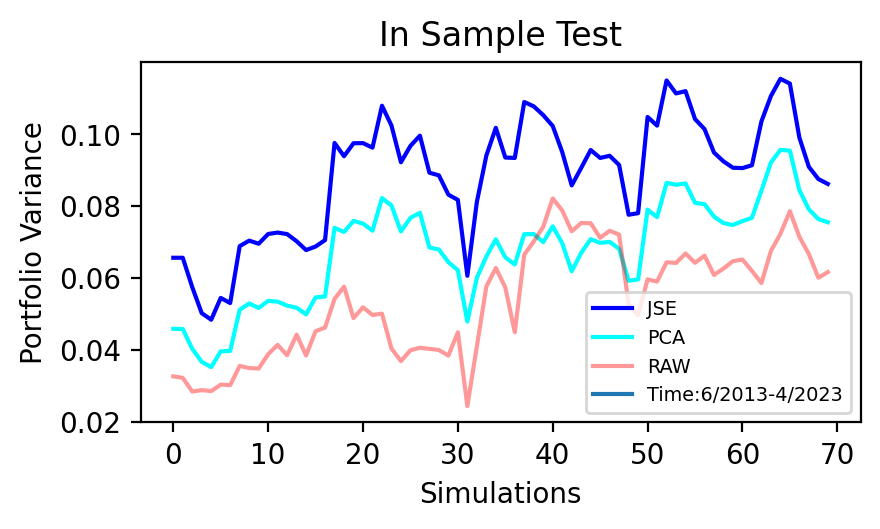

In [82]:
fig_1 = plt.figure(figsize=(4,2), dpi = 200)
axes_1 = fig_1.add_axes([0.1,0.1, 0.9, 0.9])
axes_1.set_xlabel('Simulations')
axes_1.set_ylabel('Portfolio Variance')
axes_1.set_title('In Sample Test')
axes_1.plot(varJSE, label = 'JSE', color = '#0000FF')
axes_1.plot(varPCA, label = 'PCA', color = '#00FFFF')
axes_1.plot(varRAW, label = 'RAW', color = 'red', alpha = 0.4)
axes_1.plot([], [], '', label = time_horizon1)
axes_1.legend(loc = 0, fontsize = 'x-small') #upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants





### Out of sample test

In [86]:
os_period = '10y'
os_return_type = '1mo'
os_varJSE, os_varPCA, os_varRAW, os_time = outSampleTest(os_period, os_return_type, MaxAssets,NumPeriods,12)

[*********************100%***********************]  100 of 100 completed
Optimization terminated successfully.
         Current function value: 0.312642
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.313533
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.332799
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.321884
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.148030
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.1499

<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C


         Current function value: 0.184815
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.276409
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.298118
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.124626
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.127613
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.213079
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C

         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.293100
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.292319
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.214743
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.217612
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.142852
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.141413
         Iterations: 5
         Func

<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.250824
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.262115
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.188752
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.188840
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.159247
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.158911
         Iterations: 5
         Function evaluations: 50
         Gradient evaluations: 10
Optimization ter

<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C

Optimization terminated successfully.
         Current function value: 0.269921
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.275239
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.285715
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.220131
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.222749
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.232702
         Iterations: 1
         Function evaluations: 15
         Grad

<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient



         Current function value: 0.269341
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.202652
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.212358
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.344237
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.344865
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.172402
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient



         Current function value: 0.245737
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.202763
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.200055
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.516199
         Iterations: 2
         Function evaluations: 20
         Gradient evaluations: 4
Optimization terminated successfully.
         Current function value: 0.512451
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.249025
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE C


         Current function value: 0.242194
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.203834
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.199930
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.234507
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.233661
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 0.282243
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization term

<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:112: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day_jse = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',    # Optimizer JSE Conjugate Gradient
<ipython-input-85-6b43b4c4d278>:108: OptimizeWarning: Unknown solver options: maxfev, xatol
  psi_day = minimize(Compute_Zmatrix_cost,initialGuess,method = 'CG',       # Optimizer PCA C


         Current function value: 0.168494
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.171422
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.364758
         Iterations: 3
         Function evaluations: 30
         Gradient evaluations: 6
Optimization terminated successfully.
         Current function value: 0.366257
         Iterations: 4
         Function evaluations: 40
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 0.250895
         Iterations: 1
         Function evaluations: 15
         Gradient evaluations: 3
Optimization terminated successfully.
         Current function value: 0.311891
         Iterations: 3
         Function evaluations: 35
         Gradient evaluations: 7
Optimization term

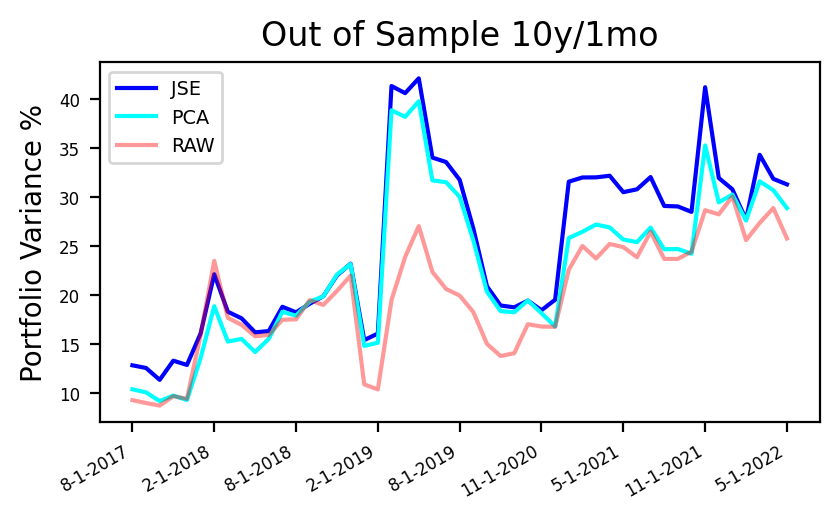

In [87]:
fig_1 = plt.figure(figsize=(4,2), dpi = 200)
axes_1 = fig_1.add_axes([0.1,0.1, 0.9, 0.9])
axes_1.xaxis.set_major_locator(ticker.MaxNLocator())
axes_1.tick_params(labelsize = 6)
axes_1.set_ylabel('Portfolio Variance %')
axes_1.set_title(f'Out of Sample {os_period}/{os_return_type}')
axes_1.plot(os_time, os_varJSE, label = 'JSE', color = '#0000FF')
axes_1.plot(os_time, os_varPCA, label = 'PCA', color = '#00FFFF')
axes_1.plot(os_time, os_varRAW, label = 'RAW', color = 'red', alpha = 0.4)
axes_1.legend(loc = 0, fontsize = 'x-small') # upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants

fig_1.autofmt_xdate()


In [5]:
var_list = [os_varJSE, os_varPCA, os_varRAW]

In [6]:
for i in var_list: 
    print(i)

0.0018639845854092796
0.0016047461416997032
0.0016097268857019021


### Bias test


Consider a sequence of out of sample demeaned portfolio returns $ x^{(1)}, x^{(2)}, ... , x^{(n)} $. Then suppose that we have the correct estimator for the standard deviation in the forecast, i.e. we have solved 
\begin{align}
w_{true} = \text{arg min} \sqrt{w^T \Sigma w} \nonumber
\end{align} 
using the true covariance matrix of asset returns, or $\Sigma$. Now consider the following sequence of random variables: 
\begin{equation}
\frac{x^{(1)}}{\sigma_{true}}, \frac{x^{(2)}}{\sigma_{true}}, ..., \frac{x^{(n)}}{\sigma_{true}}
\end{equation}
where $x^{(i)}$ is the out of sample return of $w_{true}$, and $\sigma_{true}$ is true standard deviation of the minimum variance portfolio. Although we cannot achieve this sequence with historical data, if we could, then we would essentially be drawing returns from a distribution with that specific standard deviation (true min var portfolio std). So if we were to take a large enough subset of (1), assuming n is sufficiently large, the standard deviation of this subset is going to be $\approx 1$.

Now although we do not have $\Sigma$, and thus can't solve for $w_{true}$, we can use this normazliation technique to decide which $\hat{\Sigma}$ is closest to the true covariance matrix. This would lead us to arriving at weights which are closest to $w_{true}$. Now with a better solution of $w$, the closer the standard deviation of a subset of (1) will be to 1.  

However, since we rely on data, the process will be different. Specifically (1) will become:

\begin{equation}\tag{2}
\frac{x_{JSE}^{(1)}}{\sigma_{JSE}^{(1)}}, \frac{x_{JSE}^{(2)}}{\sigma_{JSE}^{(2)}}, ..., \frac{x_{JSE}^{(n)}}{\sigma_{JSE}^{(n)}}
\end{equation}

where $x_{JSE}^{(i)}$ is calculated using $w_{JSE}^{(i)}$, and $\sigma_{JSE}^{(i)}$ is simply the standard deviation of the model at that time step. We can view each element of this sequence as a normalized random variable whose standard deviation *should* be one. We capture a large sequence of these random variables and utilize a sliding window technique to take standard deviations accordingly. We then plot these standard deviations as a function of steps in the sliding window. These calculations are also made for PCA and RAW covariance matrices.  

In order to identify how large the subset must be, we take accumulated standard deviations to see the speed of convergence towards one.


In [5]:
#good to try
#10y, 1mo, 50, 24
#1y, 1d, 50, 24
#3y, 1d, 5

biasPeriod = '10y'
biasReturntype = '1mo'
bias_num_assets = 50
bias_tframe = 25
subset = 30
subJSE, subPCA, subRAW, iterations, time_horizon, acc_std = biasTest(biasPeriod, biasReturntype, bias_num_assets, bias_tframe, subset)

[*********************100%***********************]  50 of 50 completed


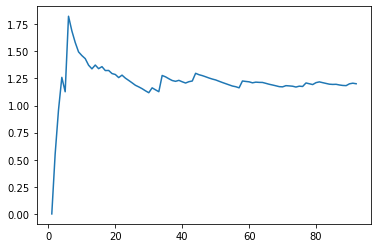

In [6]:
plt.plot(acc_std)

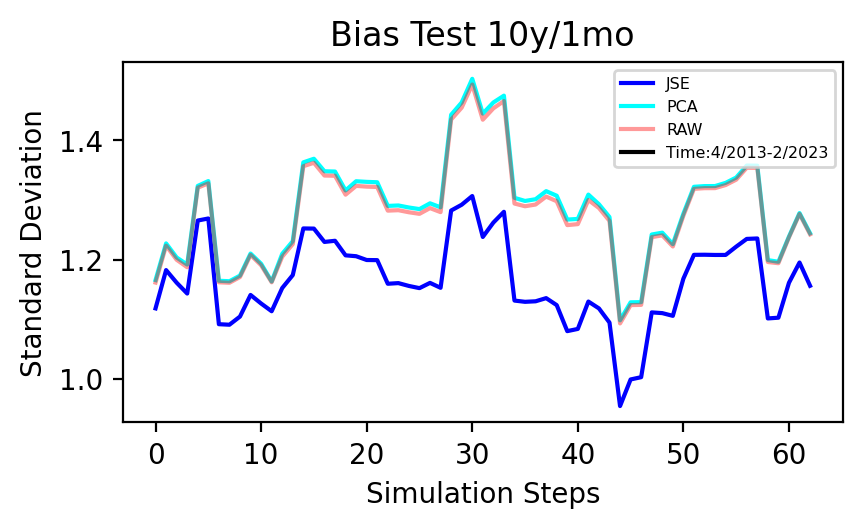

In [7]:
fig_2 = plt.figure(figsize=(4,2), dpi = 200)
axes_2 = fig_2.add_axes([0.1,0.1, 0.9, 0.9])
axes_2.set_xlabel('Simulation Steps')
axes_2.set_ylabel('Standard Deviation')
axes_2.set_title(f'Bias Test {biasPeriod}/{biasReturntype}')
axes_2.plot(subJSE, label = 'JSE', color = '#0000FF')
axes_2.plot(subPCA, label = 'PCA', color = '#00FFFF')
axes_2.plot(subRAW, label = 'RAW', color = 'red', alpha = 0.4)
axes_2.plot([], [], '',color = 'black', label = time_horizon)
axes_2.legend(loc = 1, fontsize = 'xx-small') #upper right: 1, upper left: 2, lower left: 3, lower right: 4 like the four quadrants

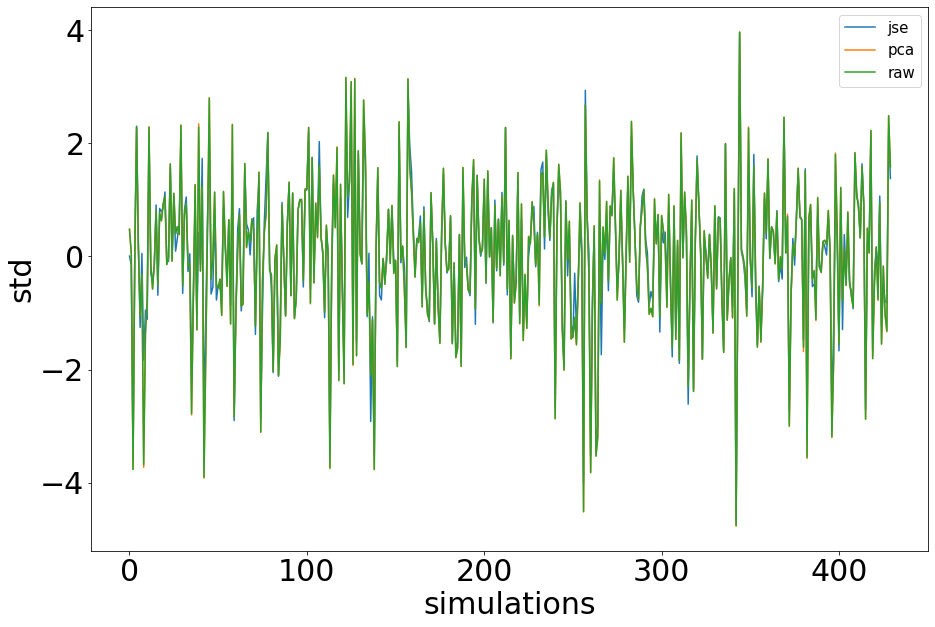

In [15]:
plt.plot(varJSE, label = 'jse')
plt.plot(varPCA, label = 'pca')
plt.plot(varRAW, label = 'raw')
plt.xlabel("simulations")
plt.ylabel("std")
plt.rcParams["figure.figsize"] = (15,10)
plt.legend(prop = {'size': 15})
plt.rcParams.update({'font.size': 8})
plt.show()

In [46]:
os.listdir()

['.ipynb_checkpoints',
 'Bias Test 1yr Daily.png',
 'JSE_first_sim-Copy1.ipynb',
 'JSE_first_sim.ipynb',
 'JSE_first_sim_TEMPPPP.ipynb',
 'JSE_IS_OS_BT.ipynb',
 'temp_JSE_SIM.ipynb',
 'Untitled.ipynb',
 'Untitled1.ipynb']

In [3]:
np.zeros((3,3,5))

array([[[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]],

       [[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]])

In [7]:
np.random.normal(1, 0, 500).shape

(500,)

In [19]:
betas = np.random.randn(1,5)
betas

array([[-1.9670887 , -1.61211495, -0.20355843, -0.25436548, -0.44996444]])

In [27]:
fact_ret = np.array([ [[1,2,3],
                       [4,5,6]],[[7,8,9],
                                 [7,8,9]] ])
fact_ret[:,:,0]

array([[1, 4],
       [7, 7]])

In [23]:
np.outer(betas, fact_ret)

array([[-1.9670887 , -1.9670887 , -1.9670887 ],
       [-1.61211495, -1.61211495, -1.61211495],
       [-0.20355843, -0.20355843, -0.20355843],
       [-0.25436548, -0.25436548, -0.25436548],
       [-0.44996444, -0.44996444, -0.44996444]])

In [7]:
myGlobal = 1
def testing():
    if myGlobal == 1: 
        print('wow')
    elif myGlobal == 0: 
        print('no')

testing()

wow


In [25]:
z=np.ones(6)
np.diag(z)

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [23]:
z = [1]*5

In [27]:
np.diag([1]*0.4)

array([[3, 0, 0],
       [0, 3, 0],
       [0, 0, 3]])

In [28]:
x = np.array([1,2,3])
np.matmul(x, [[1],[1],[1]])

array([6])

In [29]:
[[1],[1],[1]].shape

AttributeError: 'list' object has no attribute 'shape'